# Import

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import ticker

# Variables

In [10]:
# TODO(EASY):
    # fix units of measure, names, labels ... in graphs
# TODO(HARD):
    # Do all the chi-squared shenaningans for Absorbance

wp = 1.37*10**16  #[Hz]
vf = 1.40*10**15  #[nm/s]
Gamma_bulk = 0.476*10**14  #[Hz] # from Ashcroft-Mermin (at 100°C)
c = 299792458*10**9 # [nm/s]
z = 10**7 # [nm]
epsilonm_guess = 2

bulk_data = pd.read_csv("bulk gold dieletric functions.txt", sep="\t", header=None)
bulk_data.columns = ["lambda", "epsilon1", "epsilon2"]
epsilon1_bulk = np.array(bulk_data["epsilon1"]) # from 200nm to 900nm
epsilon2_bulk = np.array(bulk_data["epsilon2"]) # from 200nm to 900nm

np_data = pd.read_csv("G01-NPs.dat", sep="\t", header=None)
np_data.columns = ["lambda", "absorbance"]
absorbance = np.array(np_data["absorbance"])
absorbance_r = absorbance[50:201]  # _r variables are restricted to the selected fit region # I've also tried [70:171]

l = np.array(np_data["lambda"])  # from 400nm to 800nm
l_bulk = np.array(bulk_data["lambda"]) # from 200nm to 900nm
l_r = l[50:201]

# Define functions

In [11]:
def Gamma(R): # [Hz]
    return Gamma_bulk * (1+(np.pi*vf/(4*Gamma_bulk*R)))

def omega(l):  #[Hz]
    return 2*np.pi*c/l

def epsilon1(l, R):
    l=l.astype(int)-200
    try:
        e1 = epsilon1_bulk[l]+wp**2 * (1/(omega(l)**2+Gamma_bulk**2)-1/(omega(l)**2+Gamma(R)**2))
        return e1
    except:
        print("Invalid wavelength")
          
def epsilon2(l, R):
    l=l.astype(int)-200
    try:
        e2 = epsilon2_bulk[l]-wp**2/omega(l) * (Gamma_bulk/(omega(l)**2+Gamma_bulk**2)-Gamma(R)/(omega(l)**2+Gamma(R)**2))
        return e2
    except:
        print("Invalid wavelength")

def Absorbance(l, R, epsilonm, rho): # rho = [nm**(-3)]
    return np.log10(np.e)*9*z*omega(l)/c*epsilonm**(3/2)*4/3*np.pi*R**3*rho*epsilon2(l, R)/((epsilon1(l, R)+2*epsilonm)**2+(epsilon2(l, R))**2)

def Absorbance_JC(l, epsilonm, f):
    l=l.astype(int)-200
    return np.log10(np.e)*9*z*omega(l)/c*epsilonm**(3/2)*f*epsilon2_bulk[l]/((epsilon1_bulk[l]+2*epsilonm)**2+(epsilon2_bulk[l])**2)

def Chi(observed, expected):
    return ((observed-expected)**2/expected).sum()

def Chi_R_rho(R, rho):
    return Chi(absorbance_r, Absorbance(l_r, R, epsilonm_guess, rho))

def multiwrite(outfile, string):
    outfile.write(string + "\n")
    print(string)

# Fit

In [12]:
par_fit_JC, par_cov_JC = curve_fit(Absorbance_JC, l, absorbance, p0=(epsilonm_guess, 2*10**-6))
Absorbance_JC_fitted = Absorbance_JC(l, epsilonm=par_fit_JC[0], f=par_fit_JC[1])

par_fit_JC_r, par_cov_JC_r = curve_fit(Absorbance_JC, l_r, absorbance_r, p0=(epsilonm_guess, 2*10**-6))
Absorbance_JC_fitted_r = Absorbance_JC(l, epsilonm=par_fit_JC_r[0], f=par_fit_JC_r[1])

with open("outputfile.txt", "w") as outfile:
    multiwrite(outfile, "Full curve JC fit:")
    multiwrite(outfile, "espilonm_JC = " + str(par_fit_JC[0]) + " with error " + str(np.sqrt(par_cov_JC[0,0])))
    multiwrite(outfile, "f_JC = " + str(par_fit_JC[1]) + " with error " + str(np.sqrt(par_cov_JC[1,1])))
    multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_JC_fitted)))
    multiwrite(outfile, "")
    
    multiwrite(outfile, "Restricting the JC fit to 470nm-570nm:")
    multiwrite(outfile, "espilonm_JC = " + str(par_fit_JC_r[0]) + " with error " + str(np.sqrt(par_cov_JC_r[0,0])))
    multiwrite(outfile, "f_JC = " + str(par_fit_JC_r[1]) + " with error " + str(np.sqrt(par_cov_JC_r[1,1])))
    multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_JC_fitted_r)))
    multiwrite(outfile, "")

Full curve JC fit:
espilonm_JC = 2.333220212493098 with error 0.02154815015842269
f_JC = 8.220523819981989e-07 with error 1.4735482364315016e-08
Chi-squared = 36.2392719038338

Restricting the JC fit to 470nm-570nm:
espilonm_JC = 2.296916956287368 with error 0.030923506467641408
f_JC = 8.411208497336602e-07 with error 2.3661286503605366e-08
Chi-squared = 37.511963547599024



In [13]:
par_fit, par_cov = curve_fit(Absorbance, l_r, absorbance_r, p0=(10, epsilonm_guess, 3*10**-9))
Absorbance_fitted = Absorbance(l, R=par_fit[0], epsilonm=par_fit[1], rho=par_fit[2])

with open("outputfile.txt", "a") as outfile:
    multiwrite(outfile, "Fit restricted to 470nm-570nm:")
    multiwrite(outfile, "R = " + str(par_fit[0]) + " nm, with error " + str(np.sqrt(par_cov[0,0])) + "nm")
    multiwrite(outfile, "espilonm = " + str(par_fit[1]) + " with error " + str(np.sqrt(par_cov[1,1])))
    multiwrite(outfile, "rho = " + str(par_fit[2]) + " nm**-3, with error " + str(np.sqrt(par_cov[2,2])) + "nm**-3")
    multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_fitted)))
    multiwrite(outfile, "")

Fit restricted to 470nm-570nm:
R = 0.8172846134831532 nm, with error 0.020356164181395305nm
espilonm = 2.05918081454134 with error 0.012778228943741417
rho = 9.051623197088579e-07 nm**-3, with error 7.656290728016171e-08nm**-3
Chi-squared = 2.1501406366952858



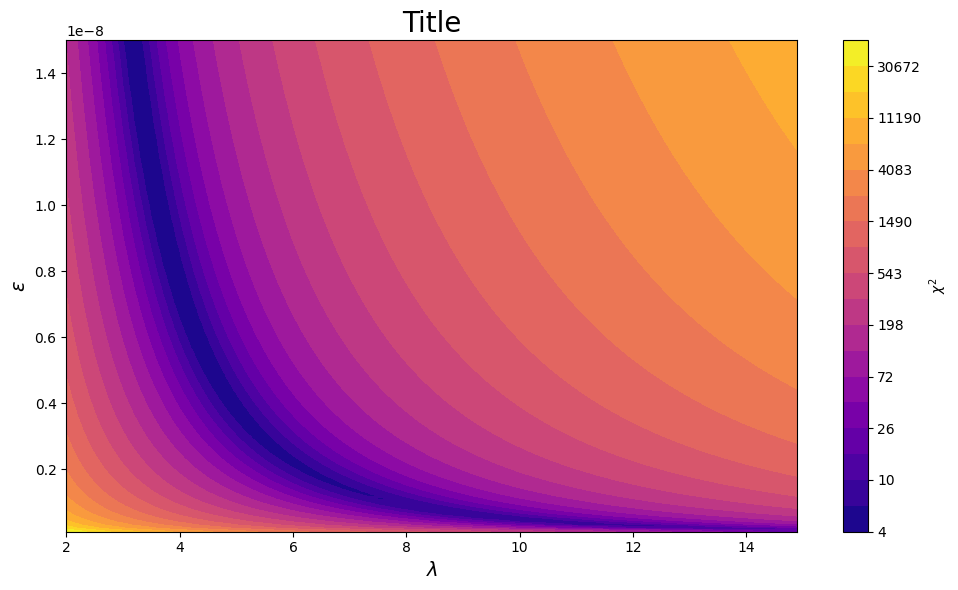

In [14]:
R_domain = np.arange(2, 15, 0.1)
rho_domain = np.arange(1*10**-10, 15*10**-9, 10**-10)

Chi_R_rho_values = np.zeros((len(R_domain), len(rho_domain)))
        
for i in range(R_domain.shape[0]):
    for j in range(rho_domain.shape[0]):
        Chi_R_rho_values[i, j] = Chi_R_rho(R_domain[i], rho_domain[j])

plt.figure(figsize=(10, 6), dpi=100)
contour_plot = plt.contourf(R_domain, rho_domain, Chi_R_rho_values.transpose(),
                            np.logspace(np.log10(Chi_R_rho_values.min()), np.log10(Chi_R_rho_values.max()), 20), locator=ticker.LogLocator(), cmap="plasma")
plt.colorbar(label=r"$\chi^2$")
plt.title("Title", fontsize=20)
plt.xlabel(r"$\lambda$", fontdict={"fontsize": 14})
plt.ylabel(r"$\epsilon$", fontdict={"fontsize": 14})
plt.tight_layout()

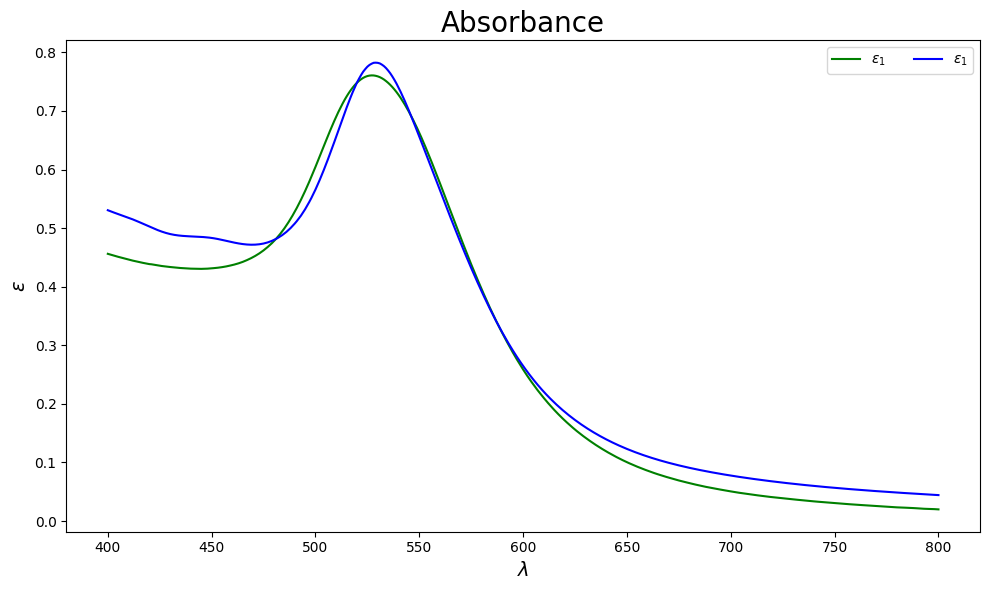

In [15]:
# Size dependent plots
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.plot(l, absorbance, color="green", label=r"$\epsilon_1$")
ax.plot(l, Absorbance_fitted, color="blue", label=r"$\epsilon_1$")
ax.set_title("Absorbance", fontsize=20)
ax.set_xlabel(r"$\lambda$", fontdict={"fontsize": 14})
ax.set_ylabel(r"$\epsilon$", fontdict={"fontsize": 14})
ax.legend(fontsize=10, ncol=2)
fig.tight_layout()
fig.savefig("plots/plot1.pdf")